In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [33]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [142]:
def get_melted_pi_tpm_table(min_cpm=None):
    assemblies = ['same_population_sample', 'afr_sample', 'european_sample']
    meta = load_meta()
    meta = meta.loc[meta.merged_run_mode==True]
    sample_d = dict([(entry.cell_line_id, entry['sample']) \
                     for ind, entry in meta.iterrows()])
    
    f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]
    df = pd.read_csv(f, sep='\t')
    df.head()
    df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
    df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
    df.rename(sample_d, axis=1, inplace=True)

    
    id_vars = ['tid']
    sample_columns = list(set(df.columns)-set(id_vars))
    tpm_df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='tpm')
    tpm_df = tpm_df.merge(meta[['sample', 'population']],
                          how='left', on='sample')
    tpm_df.head()
    
    f = '../data/analysis/04_relative_abundances_allgenes_pantrx.tsv'
    df = pd.read_csv(f, sep='\t')
    df.sort_values(by='geneid.v').head()
    df.rename({'geneid.v':'gid', 'transcriptid.v':'tid'}, axis=1, inplace=True)

    # get predominant transcripts per sample
    id_vars = ['tid', 'gid']
    sample_columns = list(set(df.columns)-set(id_vars))
    df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='pi')

    
    # filter based on min. cpm
    df = df.merge(tpm_df, how='left',
                  on=['tid', 'sample'])
    
    if min_cpm:
        df = df.loc[df.tpm >= min_cpm]
        
    return df

In [143]:
df = get_melted_pi_tpm_table(5)

df = df.sort_values(by='pi', ascending=False)
df = df.drop_duplicates(subset=['gid', 'sample'], keep='first')

In [144]:
# count the number of unique predominant transcripts per gene
# across individuals (ie not across populations)~!
temp = df[['gid', 'tid']].drop_duplicates()
temp = temp.groupby('gid').nunique().reset_index().rename({'tid':'n_t'}, axis=1)
temp.head()

,gid,n_t
0,ENSG00000000419.14,1
1,ENSG00000000938.13,1
2,ENSG00000001036.14,1
3,ENSG00000001497.18,1
4,ENSG00000001630.18,1


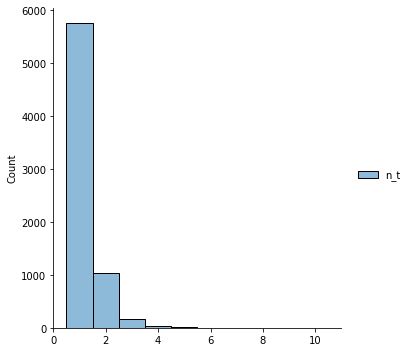

In [145]:
sns.displot(temp, kind='hist', discrete=True)

In [146]:
df.loc[df['gid']=='ENSG00000000460.17']
len(df.loc[df['gid']=='ENSG00000000460.17'])

0

In [147]:
temp.loc[temp.n_t==2]

,gid,n_t
12,ENSG00000003402.21,2
45,ENSG00000005893.17,2
47,ENSG00000006015.18,2
50,ENSG00000006576.17,2
51,ENSG00000006625.18,2
...,...,...
6972,ENSG00000310496.1,2
6979,LOC_000000000096,2
6981,LOC_000000000433,2
6990,LOC_000000001550,2


In [148]:
df.loc[df['gid']=='ENSG00000001167.15'].sort_values(by='sample')

,tid,gid,sample,pi,tpm,population


In [149]:
# plot number of unique dominant transcripts by the avg. expression 
temp2 = df[['gid', 'tpm']].groupby('gid').mean().reset_index().rename({'tpm':'mean_predom_tpm'}, axis=1)
temp2.head()

,gid,mean_predom_tpm
0,ENSG00000000419.14,72.217237
1,ENSG00000000938.13,7.412230
2,ENSG00000001036.14,14.337569
3,ENSG00000001497.18,6.590717
4,ENSG00000001630.18,8.170092


In [150]:
temp = temp.merge(temp2, on='gid', how='left')
temp.head()

,gid,n_t,mean_predom_tpm
0,ENSG00000000419.14,1,72.217237
1,ENSG00000000938.13,1,7.412230
2,ENSG00000001036.14,1,14.337569
3,ENSG00000001497.18,1,6.590717
4,ENSG00000001630.18,1,8.170092


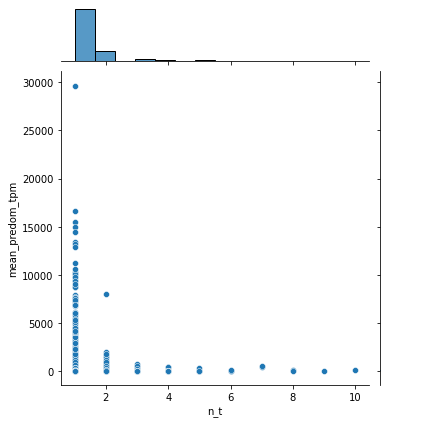

In [151]:
sns.jointplot(temp, x='n_t', y='mean_predom_tpm')

In [158]:
temp.loc[temp.n_t>1].sort_values(by='mean_predom_tpm', ascending=False).head()

,gid,n_t,mean_predom_tpm
5959,ENSG00000205542.11,2,8025.804186
3248,ENSG00000140264.22,2,2021.268605
6463,ENSG00000251562.12,2,1740.738116
4419,ENSG00000164919.11,2,1675.390616
4613,ENSG00000167526.15,2,1471.231149


In [173]:
temp.loc[temp.n_t>2].sort_values(by='mean_predom_tpm', ascending=False).head()

,gid,n_t,mean_predom_tpm
5500,ENSG00000185885.17,3,784.030442
6273,ENSG00000234745.14,7,572.618035
6374,ENSG00000243466.1_ENSG00000211592.8,3,544.662727
5627,ENSG00000196126.12,7,440.675600
1897,ENSG00000116288.13,3,422.423698


In [162]:
df.loc[df.gid=='ENSG00000205542.11', 'tid'].unique()

array(['transcript_185218', 'transcript_185237'], dtype=object)

In [183]:
def plot_thing(df, gid, tids=[]):
    temp = df.loc[df.gid==gid].copy(deep=True)
    
    if len(tids) > 0:
        temp = df.loc[df.tid.isin(tids)]
    
    # ax = sns.stripplot(temp, hue='tid', x='population', y='pi', alpha=0.5)
    ax = sns.boxplot(temp, hue='tid', x='population', y='pi')
    
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))  

In [184]:
# unfilt_df = get_melted_pi_tpm_table()

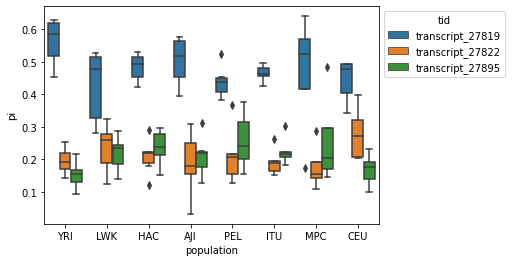

In [185]:
gid = 'ENSG00000185885.17'
tids = df.loc[df.gid==gid, 'tid'].unique()
plot_thing(unfilt_df, gid, tids)